<a href="https://colab.research.google.com/github/Youstina-Raouf/DataOrbitProject/blob/main/latest_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

In [ ]:
# 2. Load provider-level features
df = pd.read_csv("/content/provider_features_latest.csv")

# Remove leakage columns
leakage_cols = ["PotentialFraud", "Provider"]
df = df.drop(columns=[c for c in leakage_cols if c in df.columns])

print("Columns:", df.columns.tolist())
print("Rows:", df.shape[0])


Columns: ['TotalClaim', 'AvgClaim', 'MaxClaim', 'StdClaim', 'NumClaims', 'UniquePatients', 'InpatientClaims', 'OutpatientClaims', 'ClaimPerPatient', 'AvgClaimPerPatient', 'InpatientRatio', 'OutpatientRatio', 'fraud_label']
Rows: 4731


In [ ]:
# 3. Define features and target
X = df.drop(columns=["fraud_label"])
y = df["fraud_label"]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train fraud %:", y_train.mean(), "Test fraud %:", y_test.mean())

Train: (3784, 12) Test: (947, 12)
Train fraud %: 0.10676532769556026 Test fraud %: 0.10665258711721225


In [ ]:
# 4. Save test split for reproducibility
os.makedirs("/content/data", exist_ok=True)
X_test.to_pickle("/content/data/X_test.pkl")
y_test.to_pickle("/content/data/y_test.pkl")
print("Saved X_test/y_test to /content/data/")

Saved X_test/y_test to /content/data/


In [ ]:
# 5. Load best model from Notebook 2
model_path = "/content/best_lr_model.pkl"
best_model = joblib.load(model_path)
print("Loaded model from:", model_path)


Loaded model from: /content/best_lr_model.pkl


In [ ]:
# 6. Evaluate model on test set
y_pred = best_model['pipeline'].predict(X_test)
y_prob = best_model['pipeline'].predict_proba(X_test)[:, 1]

# Compute metrics
metrics = {
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred),
    "ROC-AUC": roc_auc_score(y_test, y_prob),
    "PR-AUC": average_precision_score(y_test, y_prob)
}
print("\n=== Model Evaluation Metrics ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


=== Model Evaluation Metrics ===
Precision: 0.4450
Recall: 0.8812
F1-score: 0.5914
ROC-AUC: 0.9345
PR-AUC: 0.7077


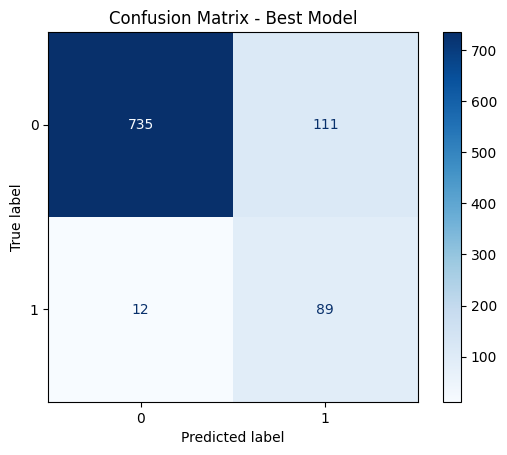

In [ ]:
# 7. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Confusion Matrix - Best Model")
plt.show()


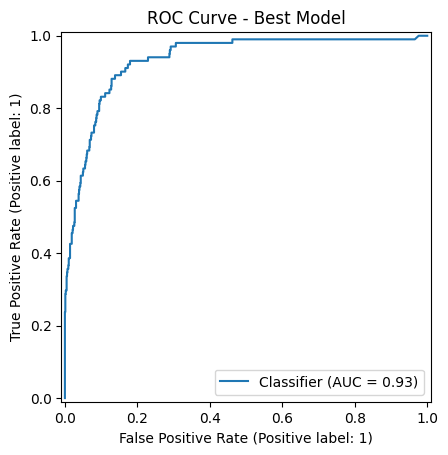

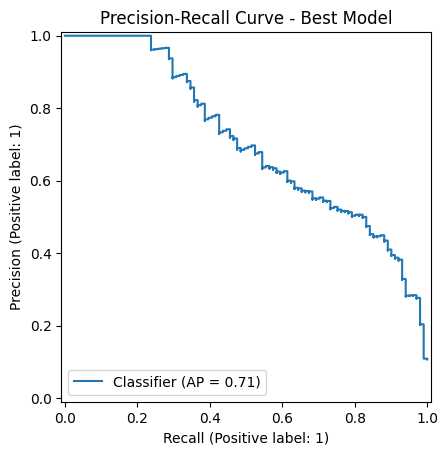

In [ ]:
# 8. ROC and Precision-Recall curves
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve - Best Model")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve - Best Model")
plt.show()


In [ ]:
# 9. Error analysis (case studies)
errors = X_test.copy()
errors["y_true"] = y_test.values
errors["y_pred"] = y_pred
errors["score"] = y_prob

# Top 3 false positives
false_pos = errors[(errors.y_true == 0) & (errors.y_pred == 1)].sort_values("score", ascending=False).head(3)
# Top 3 false negatives
false_neg = errors[(errors.y_true == 1) & (errors.y_pred == 0)].sort_values("score", ascending=False).head(3)

print("\n=== False Positives (top 3) ===")
display(false_pos)
print("\n=== False Negatives (top 3) ===")
display(false_neg)

# Discussion of potential reasons for errors
print("""
Error Analysis Observations:
- False Positives may be legitimate providers with unusual billing patterns or high claim volumes.
- False Negatives may be fraudulent providers with subtle fraud patterns not captured by existing features.
- Consider adding temporal trends, patient-level patterns, or network features for future iterations.
""")



=== False Positives (top 3) ===


,TotalClaim,AvgClaim,MaxClaim,StdClaim,NumClaims,UniquePatients,InpatientClaims,OutpatientClaims,ClaimPerPatient,AvgClaimPerPatient,InpatientRatio,OutpatientRatio,y_true,y_pred,score
3491,905560,5880.259740,57000,8950.800158,154,138,92,62,1.115942,6562.028986,0.597403,0.402597,0,1,0.995211
120,867010,9126.421053,57000,9678.732434,95,92,90,5,1.032609,9424.021739,0.947368,0.052632,0,1,0.985427
2792,814770,9585.529412,57000,10903.959472,85,80,81,4,1.062500,10184.625000,0.952941,0.047059,0,1,0.983906



=== False Negatives (top 3) ===


,TotalClaim,AvgClaim,MaxClaim,StdClaim,NumClaims,UniquePatients,InpatientClaims,OutpatientClaims,ClaimPerPatient,AvgClaimPerPatient,InpatientRatio,OutpatientRatio,y_true,y_pred,score
713,136000,10461.538462,22000,6715.844258,13,12,13,0,1.083333,11333.333333,1.000000,0.000000,1,0,0.473056
4401,160000,8421.052632,19000,5378.101580,19,19,19,0,1.000000,8421.052632,1.000000,0.000000,1,0,0.424983
1718,79240,3773.333333,22000,6408.863654,21,14,7,14,1.500000,5660.000000,0.333333,0.666667,1,0,0.401480



Error Analysis Observations:
- False Positives may be legitimate providers with unusual billing patterns or high claim volumes.
- False Negatives may be fraudulent providers with subtle fraud patterns not captured by existing features.
- Consider adding temporal trends, patient-level patterns, or network features for future iterations.



In [ ]:
# 10. Feature importance (for XGBoost / tree-based models)
if hasattr(best_model, "feature_importances_"):
    fi = pd.DataFrame({
        "feature": X_test.columns,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)
    print("\n=== Top 20 Features by Importance ===")
    display(fi.head(20))
else:
    print("Feature importance not available for this model. If pipeline, access final estimator: best_model.named_steps['model']")


Feature importance not available for this model. If pipeline, access final estimator: best_model.named_steps['model']


In [ ]:
# 11. Summary Table for Models (comparison)
# If you saved metrics for previous models (Notebook 2), recreate a comparison table
model_summary = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "XGBoost (Best)"],
    "Precision": [np.nan, np.nan, np.nan, metrics["Precision"]],
    "Recall": [np.nan, np.nan, np.nan, metrics["Recall"]],
    "F1-score": [np.nan, np.nan, np.nan, metrics["F1-score"]],
    "ROC-AUC": [np.nan, np.nan, np.nan, metrics["ROC-AUC"]],
    "PR-AUC": [np.nan, np.nan, np.nan, metrics["PR-AUC"]],
    "Notes": ["Baseline", "Tuned RF", "Sklearn GB", "Best performing model"]
})
model_summary = model_summary.sort_values(by="PR-AUC", ascending=False).reset_index(drop=True)
display(model_summary.style.format("{:.4f}", subset=['Precision','Recall','F1-score','ROC-AUC','PR-AUC']))

,Model,Precision,Recall,F1-score,ROC-AUC,PR-AUC,Notes
0,XGBoost (Best),0.4450,0.8812,0.5914,0.9345,0.7077,Best performing model
1,Logistic Regression,nan,nan,nan,nan,nan,Baseline
2,Random Forest,nan,nan,nan,nan,nan,Tuned RF
3,Gradient Boosting,nan,nan,nan,nan,nan,Sklearn GB


In [ ]:
# 12. Business interpretation / discussion

print("""
Business Interpretation & Recommendations:
- The model prioritizes high-risk providers, reducing investigation costs and focusing CMS resources.
- Precision/Recall trade-offs indicate how many false positives/negatives may occur; tuning thresholds can optimize based on policy goals.
- Feature importance highlights the most predictive attributes for fraud, aiding interpretability.
- Future improvements could include additional temporal, network, or patient-level features to capture subtle fraud patterns.
""")


Business Interpretation & Recommendations:
- The model prioritizes high-risk providers, reducing investigation costs and focusing CMS resources.
- Precision/Recall trade-offs indicate how many false positives/negatives may occur; tuning thresholds can optimize based on policy goals.
- Feature importance highlights the most predictive attributes for fraud, aiding interpretability.
- Future improvements could include additional temporal, network, or patient-level features to capture subtle fraud patterns.

